# Classifying Wines

<!-- PELICAN_BEGIN_SUMMARY -->
Let's kick off the blog with learning about wines, or rather training classifiers to learn wines for us ;)

In this post, we'll take a look at the UCI Wine data, and then train Naive Bayes and SVM classifiers to predict wine 'classes

<!-- PELICAN_END_SUMMARY -->
On a recent 5-hour wifi-less bus trip I learned that Scikit-learn comes prepackaged with some interesting [datasets](http://scikit-learn.org/stable/datasets/index.html). Among them are several 'toy datasets' which don't require an internet connection, so I decided that this would be a perfect time to experiment with building classifiers! As a result of not having internet, this post will track how I went about working with a dataset where I didn't initially have any idea how it would be structured or formatted.

We'll focus on a small wine database which carries a categorical label for each wine along with several continuous-valued features. There are three different wine 'categories' and our goal will be to classify an unlabeled wine according to its characteristic features such as alcohol content, flavor, hue etc. 

## Load and Organize Data

First let's import the usual data science modules!

In [72]:
%matplotlib inline
from sklearn import datasets
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, learning_curve 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier

Now from the skearn datasets let's load the 'wine' dataset and see whats all in there.

In [3]:
raw_data = datasets.load_wine()
raw_data

{'DESCR': 'Wine Data Database\n====================\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 178 (50 in each of three classes)\n    :Number of Attributes: 13 numeric, predictive attributes and the class\n    :Attribute Information:\n \t\t- 1) Alcohol\n \t\t- 2) Malic acid\n \t\t- 3) Ash\n\t\t- 4) Alcalinity of ash  \n \t\t- 5) Magnesium\n\t\t- 6) Total phenols\n \t\t- 7) Flavanoids\n \t\t- 8) Nonflavanoid phenols\n \t\t- 9) Proanthocyanins\n\t\t- 10)Color intensity\n \t\t- 11)Hue\n \t\t- 12)OD280/OD315 of diluted wines\n \t\t- 13)Proline\n        \t- class:\n                - class_0\n                - class_1\n                - class_2\n\t\t\n    :Summary Statistics:\n    \n    ============================= ==== ===== ======= =====\n                                   Min   Max   Mean     SD\n    ============================= ==== ===== ======= =====\n    Alcohol:                      11.0  14.8    13.0   0.8\n    Malic Acid:                   0.74  5.80   

It's a dictionary with some extra info besides the actual data. And one of the keys is `'DESCR'`, so let's start by taking a look at that. By `print`ing it, we can see the formatted text... 

In [4]:
print(raw_data['DESCR'])

Wine Data Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- 1) Alcohol
 		- 2) Malic acid
 		- 3) Ash
		- 4) Alcalinity of ash  
 		- 5) Magnesium
		- 6) Total phenols
 		- 7) Flavanoids
 		- 8) Nonflavanoid phenols
 		- 9) Proanthocyanins
		- 10)Color intensity
 		- 11)Hue
 		- 12)OD280/OD315 of diluted wines
 		- 13)Proline
        	- class:
                - class_0
                - class_1
                - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash: 

Excellent! This is just what we needed to understand how to think about and use this data set. The key points:
1. there are 3 classes (creatively named `'class_0'`, `'class_1'`, and `'class_2'`). It's likely these correspond to some typical wine varietals like Pinot Noir, or Cabernet, or Merlot...
2. there are 13 numerical attributes detailing things like alcohol perentage, ash (am I drinking ash every weekend?), Flavanoids, etc. 

Since this is a dictionary, let's also print out the other key/value pairs so we can decide how we'll format a data structure useful for our needs. The `dict.items()` method allows easy access to the key/values in a for loop. 

In [5]:
for key,value in raw_data.items():
    print(key,'\n',value,'\n')

feature_names 
 ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline'] 

DESCR 
 Wine Data Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- 1) Alcohol
 		- 2) Malic acid
 		- 3) Ash
		- 4) Alcalinity of ash  
 		- 5) Magnesium
		- 6) Total phenols
 		- 7) Flavanoids
 		- 8) Nonflavanoid phenols
 		- 9) Proanthocyanins
		- 10)Color intensity
 		- 11)Hue
 		- 12)OD280/OD315 of diluted wines
 		- 13)Proline
        	- class:
                - class_0
                - class_1
                - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ===================

Everything looks good. We are most interested in the `'data'` and `'target'` fields. Let's quickly check their shapes. 

In [6]:
print('data.shape\t',raw_data['data'].shape,
      '\ntarget.shape \t',raw_data['target'].shape)

data.shape	 (178, 13) 
target.shape 	 (178,)


That looks good, we've confirmed that we have 178 samples (rows) and 13 features (columns). Now let's build a pandas DataFrame to hold our data so that we can make use of all of its snazzy features. Then we'll take a look at the first few entries.

In [7]:
features = pd.DataFrame(data=raw_data['data'],columns=raw_data['feature_names'])
data = features
data['target']=raw_data['target']
data['class']=data['target'].map(lambda ind: raw_data['target_names'][ind])
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,class_0


We can also get some summary statistics now that we have a DataFrame. 

In [8]:
data.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


What is the distrbution of alcohol content among all of the wines?

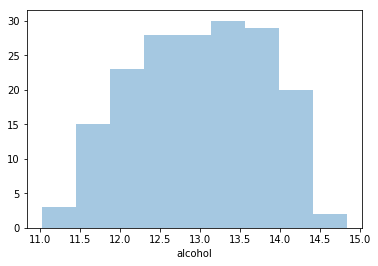

In [9]:
sns.distplot(data['alcohol'],kde=0)


What is the distribution of alcohol content by class?

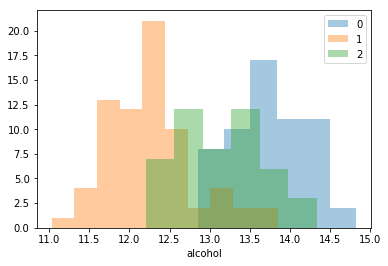

In [10]:
for i in [0,1,2]:
    sns.distplot(data['alcohol'][data.target==i],
                 kde=0,label='{}'.format(i))
plt.legend()


Interestingly, the three classes seem to naturally separate as  low/mid/high alcohol distrubtions. What are the distributions of the classes for the rest of the features? 
We'll use Seaborn's `.kdeplot()` method so we can cleanly distinguish each class. However, note that this scales the y-axis so that the integral under each curve is 1.

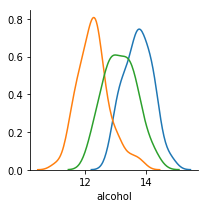

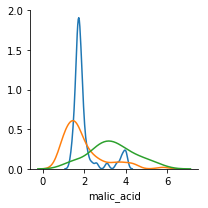

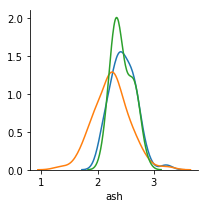

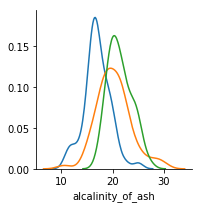

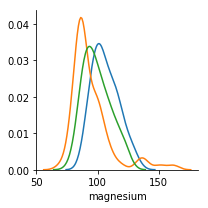

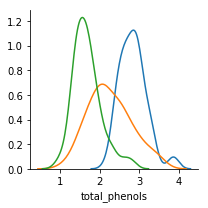

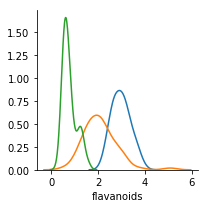

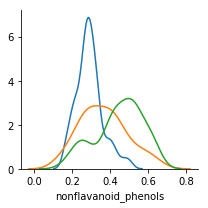

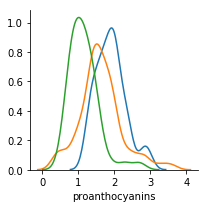

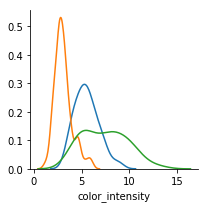

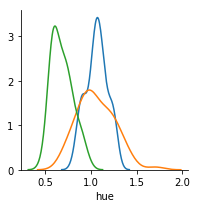

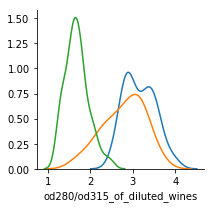

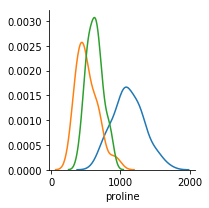

In [11]:
for feature in raw_data['feature_names']:
    facet = sns.FacetGrid(data=data,hue='class')
    facet.map(sns.kdeplot,feature)

For some of the features such as flavanoids and total phenols, it is clear the class distributions have quite different means. In fact, we could imagine, that by modeling each distribution as a Gaussian, and then given the features of a unknown wine, we might be able to classify it by looking at each feature and selecting the class that has the highest probability density, and then summing the selections over each feature. This is essentially what Gaussian Naive Bayes does, so we'll give a try as our classifier. Anyway, it's always best to start with the simplest model that makes sense before moving into more complicated models that obfuscate any interpretation of the data. 

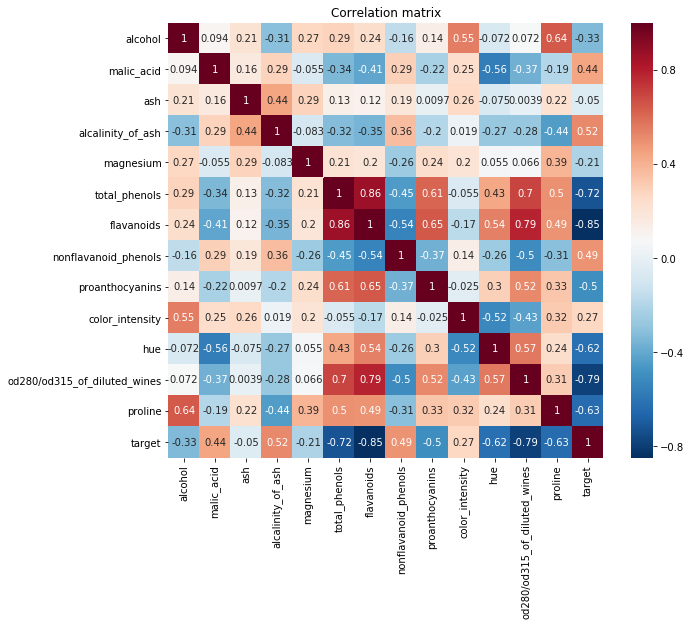

In [61]:
correlation_matrix = data.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True,annot=True,cmap='RdBu_r')
plt.title('Correlation matrix')
plt.show()

## Split data

In order to effectively train and test our model, we need to separate the data into a training set which we will feed to our model along the the training labels. Then after we have trained the model, we will test it on the 'test' data, so that we can gauge the real-world applicability of the model.

Scikit-learn has a useful functionality here with the `train_test_split()` method. `test_size` governs the proportion of data that is reserved for testing. We want to train on enough data that our model can make good predictions but we also need enough test data to determine if we've overfit the model. We'll use 20% of the data for testing.

In [12]:
data_train, data_test, label_train, label_test = \
    train_test_split(raw_data['data'],raw_data['target'],
                     test_size=0.2)
print(len(data_train),' samples in training data\n',
      len(data_test),' samples in test data\n', )

142  samples in training data
 36  samples in test data



Often the features will require some preprocessing. Scikit-learn makes this easy to do with the Pipeline module. Here, however, we are just going to use the features as they are provided. We'll just specify which classifier we want which is Gaussian Naive Bayes. GaussianNB treats models each feature as a gaussian within each class, which, as we saw above, may be an adequate representation of the data. The one drawback of GaussianNB is that is treats each feature independently (hence 'naive' bayes) so that coupling between features is ignored. 

## Model selection/validation

There are many classifcation algorithms to choose through, so let's throw them all at our problem and pick the one that performs best. To do that we'll create a dict of all of the scikit-learn classifiers. 

In [95]:
dict_classifiers = {
    "Logistic Regression": 
            {'classifier': LogisticRegression(),
                'params' : [
                            {
                             'penalty': ['l1','l2'],
                             'C': [0.001,0.01,0.1,1,10,100,1000]
                            }
                           ]
            },
    "Nearest Neighbors": 
            {'classifier': KNeighborsClassifier(),
                 'params': [
                            {
                            'n_neighbors': [1, 3, 5, 10],
                            'leaf_size': [3, 30]
                            }
                           ]
            },
             
    "Linear SVM": 
            {'classifier': SVC(),
                 'params': [
                            {
                             'C': [1, 10, 100, 1000],
                             'gamma': [0.001, 0.0001],
                             'kernel': ['linear']
                            }
                           ]
            },
    "Gradient Boosting Classifier": 
            {'classifier': GradientBoostingClassifier(),
                 'params': [
                            {
                             'learning_rate': [0.05, 0.1],
                             'n_estimators' :[50, 100, 200],
                             'max_depth':[3,None]
                            }
                           ]
            },
    "Decision Tree":
            {'classifier': tree.DecisionTreeClassifier(),
                 'params': [
                            {
                             'max_depth':[3,None]
                            }
                             ]
            },
    "Random Forest": 
            {'classifier': RandomForestClassifier(),
                 'params': {}
            },
    "Neural Net": 
            {'classifier': MLPClassifier(),
                 'params': [
                            {
                             'hidden_layer_sizes': [(100,),(10,10)]
                            }
                           ]
            },
    "Naive Bayes": 
            {'classifier': GaussianNB(),
                 'params': {}
            }
}

In [130]:
no_classifiers = len(dict_classifiers.keys())
def batch_classify(X_train, Y_train, X_test, Y_test, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,4)), columns = ['classifier', 'train_score', 'test_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.clock()
        grid = GridSearchCV(classifier['classifier'], 
                      classifier['params'],
                      refit=True,
                        cv = 10, # split into 10 groups: 9 for training, 1 for testing
                        scoring = 'accuracy', # scoring metric
                        n_jobs = -1
                        )
        estimator = grid.fit(X_train, Y_train)
        t_end = time.clock()
        t_diff = t_end - t_start
        train_score = estimator.score(X_train, Y_train)
        test_score = estimator.score(X_test, Y_test)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'test_score'] = test_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
        plot_learning_curve(estimator, 
                              "{} accuracy vs. training set size".format(key),
                              X_train,
                              Y_train,
                              cv=10)
    return df_results

trained Random Forest in 0.25 s
trained Gradient Boosting Classifier in 0.82 s
trained Naive Bayes in 0.18 s
trained Decision Tree in 0.21 s
trained Linear SVM in 0.49 s
trained Logistic Regression in 0.39 s
trained Nearest Neighbors in 0.25 s
trained Neural Net in 0.24 s


/anaconda3/envs/pelican-blog/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/pelican-blog/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/pelican-blog/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/pelican-blog/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

,classifier,train_score,test_score,training_time
0,Random Forest,1.000000,1.000000,0.247673
1,Gradient Boosting Classifier,1.000000,1.000000,0.816974
2,Naive Bayes,0.985915,1.000000,0.183001
5,Logistic Regression,1.000000,1.000000,0.390587
4,Linear SVM,1.000000,0.972222,0.490712
3,Decision Tree,0.992958,0.944444,0.213646
6,Nearest Neighbors,1.000000,0.833333,0.251246
7,Neural Net,0.542254,0.638889,0.237751


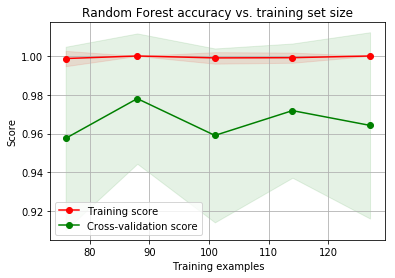

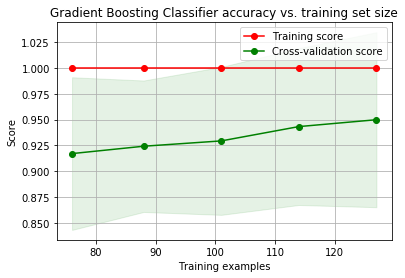

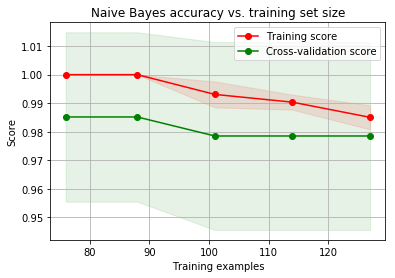

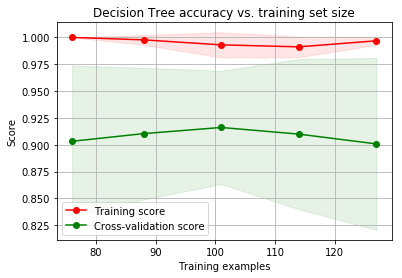

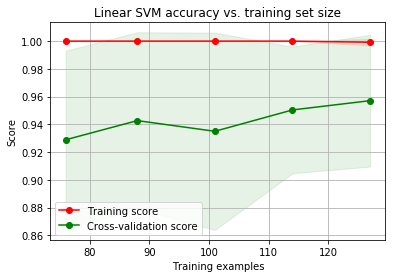

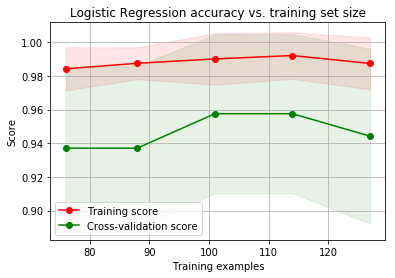

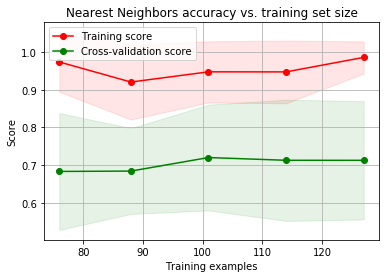

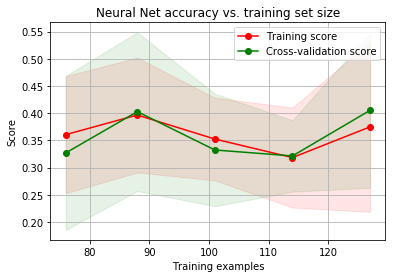

In [131]:
df_results = batch_classify(data_train, label_train, data_test, label_test)
display(df_results.sort_values(by='test_score', ascending=False))

In [13]:
pipeline=Pipeline([
    ('classifier', GaussianNB()) # Naive Bayes Classifier
])
params = {}

Now we'll train our model, splitting the training data up into 10 groups--9 for training and 1 for testing. We'll do that procedure 10 times, to see if the 'accuracy' score deviates much which would be an indicator of a bad model or bad data.

In [14]:
scores = cross_val_score(pipeline, # specifies classifier
                        data_train, # training data
                        label_train, # training labels
                        cv = 10, # split into 10 groups: 9 for training, 1 for testing
                        scoring = 'accuracy', # scoring metric
                        n_jobs = -1
                        )
print(scores)

[0.93333333 1.         1.         1.         1.         1.
 1.         0.92857143 0.92307692 1.        ]


It looks like the naive bayes classifier works quite well, often predicting wine classes with 100% accuracy.  

In [15]:
grid = GridSearchCV(pipeline, # convert raw messages to a model
                      params,
                      refit=True,
                        cv = 10, # split into 10 groups: 9 for training, 1 for testing
                        scoring = 'accuracy', # scoring metric
                        n_jobs = -1
                        )


In [16]:
% time wine_detector = grid.fit(data_train,label_train)

CPU times: user 125 ms, sys: 49.6 ms, total: 175 ms
Wall time: 276 ms


In [17]:
% time wine_detector = GaussianNB().fit(data_train,label_train)

CPU times: user 3.06 ms, sys: 2.05 ms, total: 5.11 ms
Wall time: 4.67 ms


In [31]:
predictions = wine_detector.predict(data_test)
print('accuracy', accuracy_score(label_test, predictions))
print('confusion matrix\n', 
      confusion_matrix(label_test, predictions))
print('(row=expected, col=predicted)')

accuracy 1.0
confusion matrix
 [[14  0  0]
 [ 0 12  0]
 [ 0  0 10]]
(row=expected, col=predicted)


In [116]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.6, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


CPU times: user 255 ms, sys: 4.82 ms, total: 260 ms
Wall time: 277 ms


<module 'matplotlib.pyplot' from '/anaconda3/envs/pelican-blog/lib/python3.5/site-packages/matplotlib/pyplot.py'>

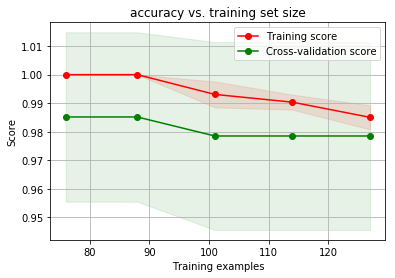

In [129]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", data_train, label_train, cv=10)

In [21]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))

Now let's try an SVM classifier to see if we get any better performance. 

In [32]:
pipeline_svm = Pipeline([
    ('classifier', SVC()),  # SVC
])

# pipeline parameters to automatically explore and tune
param_svm = [
      {'classifier__C': [1, 10, 100, 1000],
   'classifier__gamma': [0.001, 0.0001],
   'classifier__kernel': ['linear']}
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=5 )  # what type of cross validation to use
)


In [33]:
%time svm_detector = grid_svm.fit(data_train, label_train) # find the best combination from param_svm
#print(svm_detector.grid_scores_)

CPU times: user 9.48 s, sys: 85 ms, total: 9.57 s
Wall time: 9.85 s


In [34]:
print(svm_detector.best_estimator_)

Pipeline(memory=None,
     steps=[('classifier', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


In [35]:
svm_estimator = SVC(gamma=0.001,kernel='linear',C=1)

CPU times: user 212 ms, sys: 224 ms, total: 436 ms
Wall time: 692 ms


<module 'matplotlib.pyplot' from '/anaconda3/envs/pelican-blog/lib/python3.5/site-packages/matplotlib/pyplot.py'>

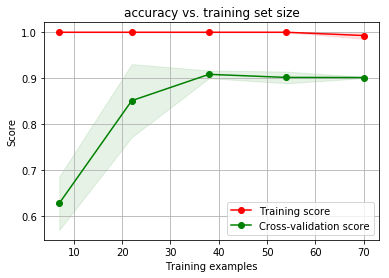

In [36]:
%time plot_learning_curve(svm_estimator, "accuracy vs. training set size", data_train, label_train, cv=2)

In [37]:
predictions = svm_detector.predict(data_test)
print('accuracy', accuracy_score(label_test, predictions))
print('confusion matrix\n', 
      confusion_matrix(label_test, predictions))
print('(row=expected, col=predicted)')

accuracy 0.9722222222222222
confusion matrix
 [[14  0  0]
 [ 0 12  0]
 [ 0  1  9]]
(row=expected, col=predicted)


In [62]:
pipeline_knc = Pipeline([
    ('classifier', KNeighborsClassifier()),  # SVC
])

# pipeline parameters to automatically explore and tune
param_knc = [
      {'classifier__n_neighbors': [1, 3, 5, 10],
   'classifier__leaf_size': [3, 30]}
]

grid_knc = GridSearchCV(
    pipeline_knc,  # pipeline from above
    param_grid=param_knc,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=5 )  # what type of cross validation to use
)

In [63]:
%time knc_detector = grid_knc.fit(data_train, label_train) # find the best combination from param_svm
print(knc_detector.best_estimator_)

ValueError: Invalid parameter leaf_size for estimator Pipeline(memory=None,
     steps=[('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]). Check the list of available parameters with `estimator.get_params().keys()`.

Pipeline(memory=None,
     steps=[('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])


CPU times: user 214 ms, sys: 58.8 ms, total: 272 ms
Wall time: 354 ms


<module 'matplotlib.pyplot' from '/anaconda3/envs/pelican-blog/lib/python3.5/site-packages/matplotlib/pyplot.py'>

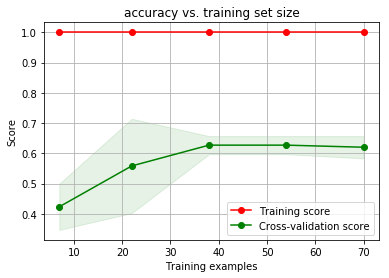

In [49]:
knc_estimator = KNeighborsClassifier(leaf_size=3,
                                     n_neighbors=1)
%time plot_learning_curve(knc_estimator, "accuracy vs. training set size", data_train, label_train, cv=2)

In [50]:
predictions = knc_detector.predict(data_test)
print('accuracy', accuracy_score(label_test, predictions))
print('confusion matrix\n', 
      confusion_matrix(label_test, predictions))
print('(row=expected, col=predicted)')

accuracy 0.8333333333333334
confusion matrix
 [[14  0  0]
 [ 0 11  1]
 [ 0  5  5]]
(row=expected, col=predicted)
